# Airbnb New User Bookings
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/

Part 1. Problem Definition
-------------------------

1a. Define problem
>How do we predict user intent based on their online/web behavior? Knowing what people's motivations are as they use a web or app can help businesses/service providers show more relevant content and generate value.

>In this report we will look at a [kaggle competition posted by Airbnb](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) that asks competitors to predict the country where a new guest will book their first travel experience. Accurate predictions allow Airbnb to share more personalized content, decrease booking time, and better forecast demand.



1b. Describe solution
> Using data provided by Airbnb about US users' demographic and web session records we will provide 5 predictions per user of where they will stay. Of the 12 possible outcomes, there are 11 destination countries ('US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU') and 1 outcome where no booking was made ('NDF').

> A supervised learner will be applied to the training data that can outperform a 'dumb' prediction of simply repeating the top 5 most frequent outcomes for each user.


1c. Identify metrics
> Our predictions will be evaluated using [NDCG](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/details/evaluation). The 5 predictions made per user will be ordered so the most probable destination goes first. The NDCG metric will give higher weight to correct predictions that are given higher in order. A perfect score is 1.

> We will aim for an NDCG score of 0.88 or higher on the Public Leaderboard (LB), which would make the top 150 (of 1000+ entries). The Public LB is calculated on 30% of the test data, while the final competition results (or, "Private LB") are based on the other 70%. We use the Public LB to evaluate our performance because most of our work was performed prior to the competition end date 02/11/16.

> As a benchmark, we find that a model which predicts the 5 most common outcomes (in order, NDF-US-Other-FR-IT) achieves a Public LB score of 0.85359 (Private LB 0.85670).


In [1]:
import cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search
%matplotlib inline

/Users/jjl/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Part 2. Exploratory analysis
-----------------------

2a. Analyze problem
> Size?
> Num features?
> Mean, variance, min/max?
> Categoricals?

> Preliminary analysis shows most users are NDF or US.

> Age and gender have many null or odd-looking values.

2b. Idenitfy ML algorithm(s)
> Classification problem.

> Decision trees will be explored, including random forest and XGBoost, which has proven to be effective in kaggle competitions.


Load the data
------------

In [5]:
# read the train and test user files
zf = zipfile.ZipFile('../data/train_users_2.csv.zip')
train = pd.read_csv(zf.open('train_users_2.csv'))


zf = zipfile.ZipFile('../data/test_users.csv.zip')
test = pd.read_csv(zf.open('test_users.csv'))


### Train data
We see that the train data has 213451 users and 15 features. The target variable is `country_destination` and there is a column `date_first_booking` that appears to indicate when the booking was made (if the target variable isn't 'NDF').

In addition, there is demographic info age and gender as well as user data such as dates of visits, signup details, and how the user accessed the service.

In [9]:
print train.shape  # 213451 rows, 16 cols
train.head()

(213451, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### Test data
The test data has 62096 users and the same 15 features found in the train set. Even though the target variable isn't present, there is still a column for `date_first_booking` that is populated with null values.


In [14]:
print test.shape  # 62096 rows, 15 cols
print test.date_first_booking.unique()  # contains only nan
test.head()

(62096, 15)
[ nan]


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari



Look closer at train users
------------------------


### Country destination (target variable)

We see that over half the users did not book a destination ('NDF'), and the 'US' was by far the most common country.

In [22]:
# make a copy of training data
users = train.copy()
# get the count and pct
pd.concat((users.country_destination.value_counts(), users.country_destination.value_counts()/users.shape[0]), axis=1)

,country_destination,country_destination
NDF,124543,0.583473
US,62376,0.292226
other,10094,0.047290
FR,5023,0.023532
IT,2835,0.013282
GB,2324,0.010888
ES,2249,0.010536
CA,1428,0.006690
DE,1061,0.004971
NL,762,0.003570


### Missing data

After replacing the value '-unknown-' in feature `gender` with nan we see that 4 features have null values. The `date_first_booking` nulls can be ignored because they will ultimately not be used to make predictions.

We expect that gender and age have an impact on a user's destination and will look at them more closely.

In [23]:
## replace missing gender data with NaN
users.gender.replace('-unknown-', np.nan, inplace=True)
## compute Nan pct, users
(users.isnull().sum() / users.shape[0]) * 100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                     44.829024
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

### Gender
Many users have missing gender info, and there are more female users than male. It also appears that the overall distribution of gender does not replicate precisely for each country, so it could be useful in our predictions.

MISSING    44.829024
FEMALE     29.534179
MALE       25.504683
OTHER       0.132115
Name: gender, dtype: float64


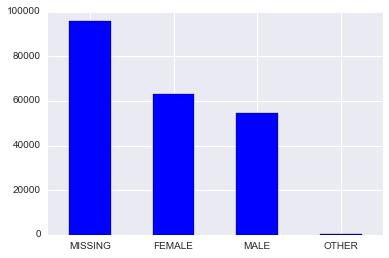

In [122]:
print users.fillna('MISSING').gender.value_counts()/users.shape[0] * 100
users.fillna('MISSING').gender.value_counts().plot(kind='bar', rot=0)
plt.show()

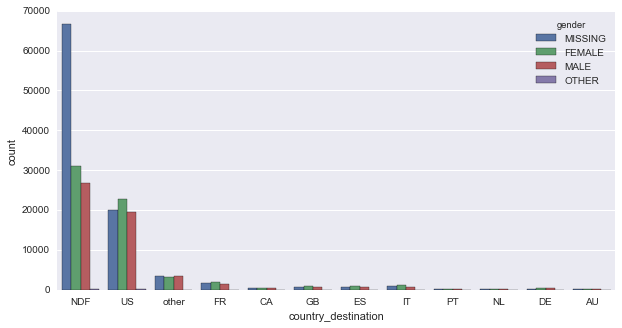

In [126]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="country_destination", data=users.fillna('MISSING'), hue="gender", 
                   hue_order=['MISSING', 'FEMALE', 'MALE', 'OTHER'])

### Age
Many users have missing age info, and many of the values appear inaccurate. There are ages as low as 1 and as high as 2014. We will address how to handle these values during feature pre-processing.

In the below chart we can see a modal peak in the 30-35 bucket, with a large proportion of users falling in the 25-35 range. After removing values above 100, we get a mean of 36.5 and median of 34.0.

In [186]:
# summary stats without removing values
users.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [193]:
# summary stats after removing values that appear to be year, not age
print 'median', np.median(users.age[users.age<100])
users.age[users.age<100].describe()

median 34.0


count    123090.000000
mean         36.530937
std          11.673194
min           1.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          99.000000
Name: age, dtype: float64

missing values: 87990
values above 1900: 779


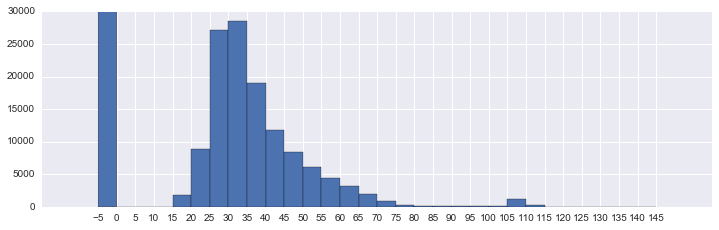

In [197]:
# look at distribution of ages, replacing nulls with -1
age_vals = train['age'].fillna(-1).values

print 'missing values:', sum(age_vals<0)
print 'values above 1900:', sum(age_vals>1900)

plt.hist(age_vals, bins=range(-5,150,5))
plt.gcf().set_size_inches(12,3.5)
plt.xticks(range(-5,150,5))
plt.ylim(0,30000)
plt.show()

Age Gender Buckets csv file
--------------------------

This file contains summary statistics of users' age group, gender, country of destination. The data is useful in exploring how user demographics seem to impact the destination, but will not be merged with the training data to make predictions. We will instead rely on our trained classifier to detect these relationships in the user data.

In [199]:
# load the age gender buckets data
zf = zipfile.ZipFile('../data/age_gender_bkts.csv.zip')
bkts = pd.read_csv(zf.open('age_gender_bkts.csv'))
bkts.tail(3)

,age_bucket,country_destination,gender,population_in_thousands,year
417,15-19,US,female,10570,2015
418,85-89,US,male,1441,2015
419,80-84,US,male,2442,2015


country_destination,age_bucket,gender,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
10,25-29,female,851,1220,2495,1280,2041,2122,1610,505,299,11011
11,25-29,male,895,1273,2593,1347,2081,2213,1673,518,309,11385


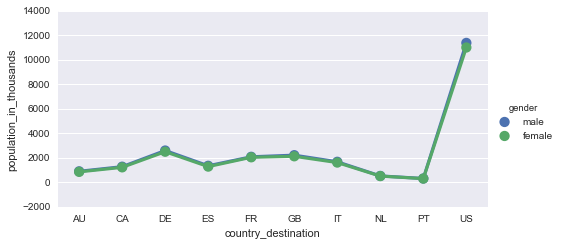

In [209]:
# create pivot table of age/gender buckets
pivot_bkts = bkts.pivot_table('population_in_thousands', ['age_bucket', 'gender'], ['country_destination'])
pivot_bkts = pd.DataFrame(pivot_bkts).reset_index()

# look at specific age buckets
choose_age = '25-29'
sns.factorplot(x="country_destination", y="population_in_thousands", \
               data=bkts[bkts.age_bucket==choose_age], hue='gender', \
               size=3.5, aspect=2.)
pivot_bkts[pivot_bkts.age_bucket==choose_age]

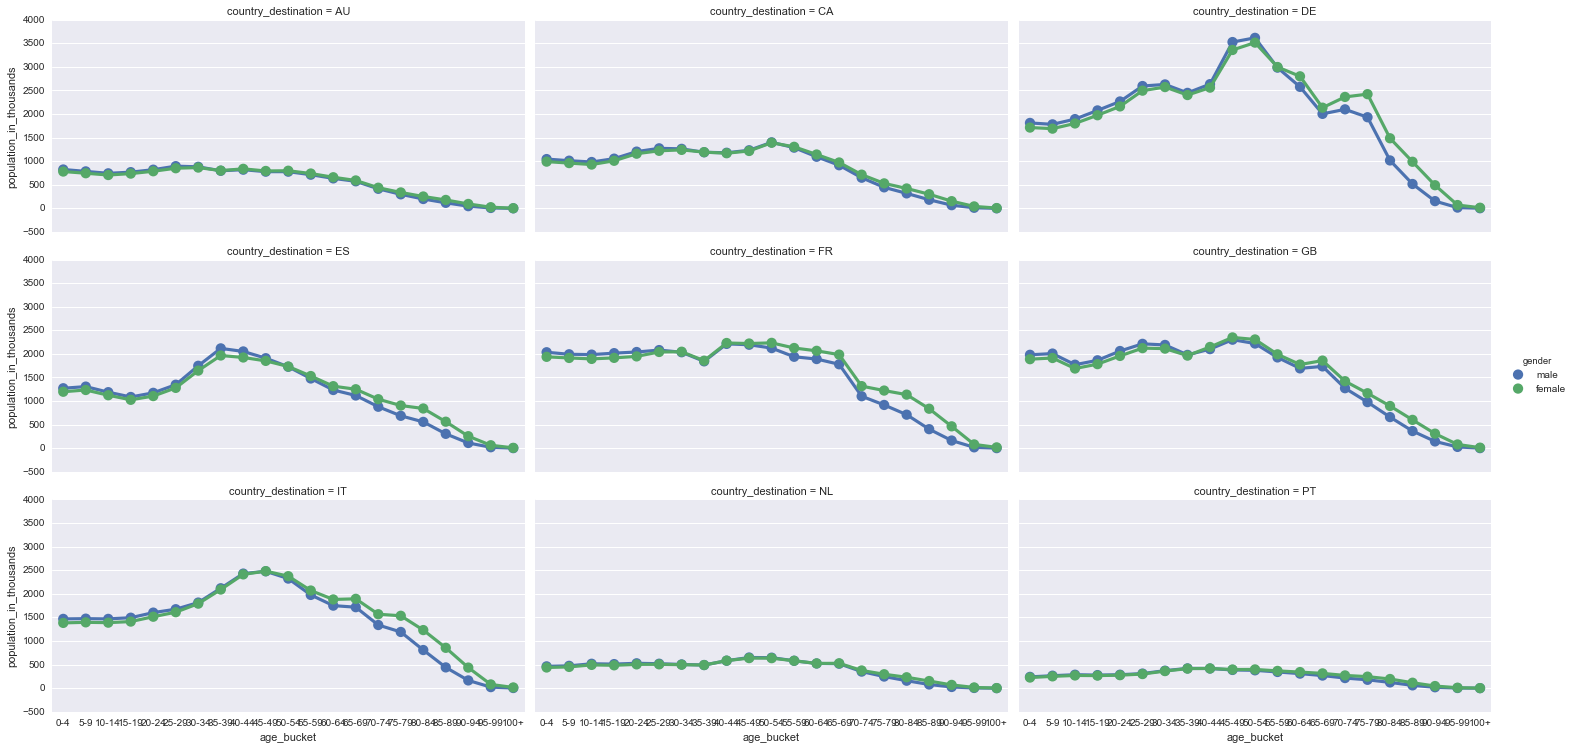

In [159]:
# look at the countries other than US
age_order = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
             '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
sns.factorplot(x="age_bucket", y="population_in_thousands", \
              data=bkts[bkts.country_destination!='US'], hue='gender', \
              size=3.5, aspect=2, order=age_order, \
              col='country_destination', col_wrap=3)

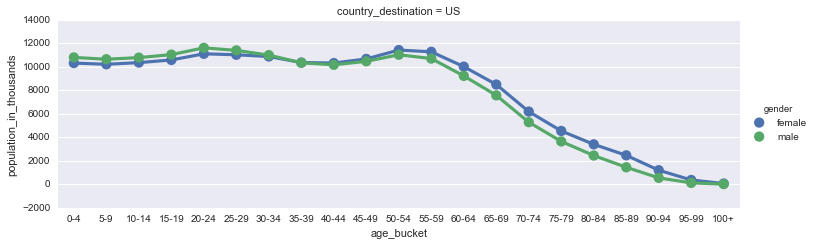

In [158]:
# look at US only
sns.factorplot(x="age_bucket", y="population_in_thousands", \
              data=bkts[bkts.country_destination=='US'], hue='gender', \
              size=3.5, aspect=3., order=age_order, \
              col='country_destination', col_wrap=1)

Countries csv file
-----------------
Some tests were performed that joined `language_levenshtein_distance` to the rest of the user data on `destination_language`, but the feature did not improve prediction accuracy and we will not use it or any other data from this file in the final solution.

In [3]:
# load the countries data
zf = zipfile.ZipFile('../data/countries.csv.zip')
countries = pd.read_csv(zf.open('countries.csv'))
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


---

Part 3. Solution implementation
--------------------------

3a. Pre-process the data
> Feature engineering, including selection and transformation.

> Dealing with missing values and outliers (age, gender).

> One hot encoding of user data features.

> Create new feature, dac - tfa.

> Merging session data with user data. Counting events based on action detail.

3b. Implement and measure performance
> User data only, random forest with cv.

> A custom scorer was found on kaggle...

3c. Iterate and reflect
> Next, model with XGBoost on user data only. Tune hyperparameters tree size, num iterations. Use built-in train/validation using merror vs mlogloss.

> Train on merged user and sessions data. First only used a subset of event types from sessions that appeared to correlate with booking a trip. Eventually settled on using all events grouped by the `action_detail` column.

> TODO: implement gridcv with xgboost using NDCG scorer.

> Ideas explored but ultimately discarded:
> - PCA reduced data to 30 dimensions didnt produce better results.
> - Cutting off age at "reasonable" point like under 14 and over 90 didn't do better.
> - Summing secs_elapsed in session data didn't improve over simply recording number of unique action_detail events.
> - Adding language_levenshtein_distance didn't improve.

> Possible ideas to explore:
> - Adding device_type from sessions as feature, perhaps recording the number of different devices per user.
> - Adding action and/or action_type to the joined session data.
> - Joining age/gender buckets.
> - 




3-1. Feature engineering
----------------------

### Combine the train and test data for pre-processing
After pre-processing we will separate the data back into train and test sets.

In [278]:
# drop the target variable from train and merge with test data
df_train = train.drop(['country_destination'], axis=1)
df_test = test.copy()
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# Remove date_first_booking, it will not be used to make predictions
df_all = df_all.drop(['date_first_booking'], axis=1)

# Fill nan
df_all = df_all.fillna(-1)

### Date features
There are two date format features (`date_account_created`, `timestamp_first_active`) that we separate into 3 columns each: year, month, day. We then create a new feature to capture the days difference between the two (`dac_tfa`).

In [279]:
# Convert date_account_created
# split date into year, month, day and create list
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)

# create new columns for year, month, day
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28


In [280]:
# Convert timestamp_first_active
# convert date to yyyymmdd
df_all['timestamp_first_active'] = df_all.timestamp_first_active//1000000

# stack yyyy, mm, dd as list
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8]]))).values)

# create new columns for year, month, day
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,gxn3p5htnn,2010-06-28,20090319,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19
1,820tgsjxq7,2011-05-25,20090523,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23
2,4ft3gnwmtx,2010-09-28,20090609,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9


In [281]:
# Calculate time difference from tfa to dac
# convert date_account_created to yyyymmdd
df_all['date_account_created'] = df_all.date_account_created.astype(str).apply(lambda x: int(x.translate(None, '-')))

# create new column
df_all['dac_tfa'] = df_all.date_account_created - df_all.timestamp_first_active
df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa
0,gxn3p5htnn,20100628,20090319,-unknown-,-1,facebook,0,en,direct,direct,...,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19,10309
1,820tgsjxq7,20110525,20090523,MALE,38,facebook,0,en,seo,google,...,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23,20002
2,4ft3gnwmtx,20100928,20090609,FEMALE,56,basic,3,en,direct,direct,...,Web,Windows Desktop,IE,2010,9,28,2009,6,9,10319


In [282]:
## remove old cols
df_all = df_all.drop(['date_account_created'], axis=1)
df_all = df_all.drop(['timestamp_first_active'], axis=1)
df_all.shape

(275547, 19)

### Age feature

We'll keep all age values between 0-99 and explore two options to deal with values >99. 

- Option 1: treat all ages 100+ the same as nulls by converting to -1. 

- Option 2: retain all values up to 1900 and will assume that those above 1900 refer to a year that we convert to age by subtracting from 2015. 

Let's go with Option 1 for now and return to Option 2 after the first model is trained.

In [229]:
# get the age values
av = df_all.age.values
# Option 1: treat ages 100+ same as na (convert to -1)
ages_option1 = np.where(av>99, -1, av)
# Option 2: convert ages 1900+ to an assumed age
ages_option2 = np.where(av>1900, 2015-av, av)

df_all['age'] = ages_option1

One hot encoding non-numerical features
-------------------------------------
We'll engineer categorical data so that each value gets a separate column with a 1 or 0 value.

In [326]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', \
             'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)
df_all.head(3)

,id,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa,gender_-unknown-,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,gxn3p5htnn,-1,2010,6,28,2009,3,19,10309,1,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,38,2011,5,25,2009,5,23,20002,0,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,56,2010,9,28,2009,6,9,10319,0,...,0,0,0,0,0,0,0,0,0,0


Prepare data for fitting the classifier
-------------------------------------
We remove user id info and [encode the target variable with a numeric label](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [257]:
#Split data back into train and test sets
vals = df_all.drop(['id'], axis=1).values
piv_train = train.shape[0]
X = vals[:piv_train]
X_test = vals[piv_train:]

# Create numeric label for each of the 12 target labels
labels = train['country_destination'].values
le = LabelEncoder()
y = le.fit_transform(labels)

In [258]:
print X.shape
print y.shape
print X_test.shape

(213451, 162)
(213451,)
(62096, 162)


Fit the classifier
-----------------
We'll train a random forest model using [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html).

A [custom NDCG scorer](https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/ndcg-scorer) from kaggle scripts will be used for training.


In [262]:
"""Metrics to compute the model performance."""
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

### Random forest
Fit the [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model with grid search.


In [266]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'class_weight': ['balanced', None],
              'max_depth': [6, 8]
             }
reg = grid_search.GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)
reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 20], 'max_depth': [6, 8], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(ndcg_score, needs_proba=True, k=5), verbose=0)

In [267]:
## get the best predictor
est = reg.best_estimator_
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [268]:
# look at the scores for parameter combinations
reg.grid_scores_

[mean: 0.39847, std: 0.12919, params: {'min_samples_split': 2, 'max_depth': 6, 'class_weight': 'balanced'},
 mean: 0.38701, std: 0.11373, params: {'min_samples_split': 20, 'max_depth': 6, 'class_weight': 'balanced'},
 mean: 0.40359, std: 0.11272, params: {'min_samples_split': 2, 'max_depth': 8, 'class_weight': 'balanced'},
 mean: 0.41582, std: 0.12218, params: {'min_samples_split': 20, 'max_depth': 8, 'class_weight': 'balanced'},
 mean: 0.79511, std: 0.00470, params: {'min_samples_split': 2, 'max_depth': 6, 'class_weight': None},
 mean: 0.79675, std: 0.00522, params: {'min_samples_split': 20, 'max_depth': 6, 'class_weight': None},
 mean: 0.79084, std: 0.00844, params: {'min_samples_split': 2, 'max_depth': 8, 'class_weight': None},
 mean: 0.79073, std: 0.00594, params: {'min_samples_split': 20, 'max_depth': 8, 'class_weight': None}]

### How accurate are the predictions?
Below we can see that the model appears to only make a correct prediction with its first guess for the two most frequent outcomes, 'NDF' and 'US'.

In [271]:
# look at how well the model predicts the training data
print 'Random Forest:\n', metrics.classification_report(y, est.predict(X))

GridSearchCV:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       539
          1       0.00      0.00      0.00      1428
          2       0.00      0.00      0.00      1061
          3       0.00      0.00      0.00      2249
          4       0.00      0.00      0.00      5023
          5       0.00      0.00      0.00      2324
          6       0.00      0.00      0.00      2835
          7       0.59      0.99      0.74    124543
          8       0.00      0.00      0.00       762
          9       0.00      0.00      0.00       217
         10       0.55      0.03      0.06     62376
         11       0.00      0.00      0.00     10094

avg / total       0.51      0.59      0.45    213451



/Users/jjl/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Submit predictions to kaggle
----------------------------
We [submit our predictions](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/submit) on the test data and get a result of 0.85407 (Private score 0.85702).

This is only slightly better than our benchmark of 0.85359 (Private 0.85670).

In [272]:
# make predictions on test set
ypred_sub = est.predict_proba(X_test)
print ypred_sub.shape  ## should be (62096, 12)

# take the 5 classes with highest probabilities
id_test = test['id']
ids = []  # to hold ids
cts = []  # to hold top 1-5 predicted countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(ypred_sub[i])[::-1])[:5].tolist()
    # use this value for cts for benchmark submission 
    #cts += ['NDF', 'US', 'other', 'FR', 'IT']
    
print len(ids)  ## should be 310480
print len(cts)

(62096, 12)
310480
310480


In [274]:
# stack ids and countries together into dataframe
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

# write dataframe to csv
sub.to_csv(path_or_buf='../submit/random_forest.csv', index=False) 

---

Improving the solution
---------------------
1. Revisit age feature
2. Merge sessions data
3. Train XGBoost classifier


1. Revisit age feature
----------------------
We'll now use Option 2 to deal with the age values >99.


In [382]:
# Option 2: convert ages 1900+ to an assumed age
df_all['age'] = ages_option2
df_all['age'].unique()

array([  -1.,   38.,   56.,   42.,   41.,   46.,   47.,   50.,   36.,
         37.,   33.,   31.,   29.,   30.,   40.,   26.,   32.,   35.,
         59.,   49.,   44.,   34.,   28.,   19.,   53.,   52.,   39.,
         57.,   25.,   54.,   69.,   63.,   43.,   55.,   65.,   58.,
         61.,   18.,    5.,   27.,   45.,   60.,   48.,   51.,   64.,
         72.,   70.,   67.,   73.,    1.,  104.,   66.,  105.,   68.,
         95.,   24.,   94.,   75.,   79.,   62.,    2.,   16.,    4.,
         23.,  101.,   98.,   76.,   74.,   87.,   92.,  115.,   71.,
         84.,  107.,   78.,   99.,  110.,  102.,   82.,   77.,   22.,
         89.,   21.,   15.,   20.,  103.,   17.,   86.,   97.,   81.,
         90.,   88.,   80.,  100.,   91.,  106.,   83.,   85.,  108.,
        113.,  109.,   93.,   96.,  111.,  112.,  150.,  132.,    7.,
         14.,   13.])

2. Merge sessions data
----------------------
We will utilize the sessions data by grouping users by `user_id` and `action_detail` and counting each unique `action_detail` event per `user_id`. This is then joined with our user data.


In [238]:
# Load session data
zf = zipfile.ZipFile('../data/sessions.csv.zip')
sessions = pd.read_csv(zf.open('sessions.csv'))
print sessions.shape
sessions.head(3)

(10567737, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301


In [291]:
# group sessions by user and action_detail
sess_uu = sessions.groupby(['user_id', 'action_detail'], as_index=False)
# count events and convert session grouping to dataframe
events_uu = pd.DataFrame({'event_count' : sess_uu.size() }).reset_index()
events_uu.head(3)

,user_id,action_detail,event_count
0,00023iyk9l,change_trip_characteristics,2
1,00023iyk9l,confirm_email_link,1
2,00023iyk9l,dashboard,4


In [292]:
# convert action_detail types to columns with pivot table
pivot_uu = events_uu.pivot_table('event_count', ['user_id'], ['action_detail'])
pivot_uu = pd.DataFrame(pivot_uu.fillna(0)).reset_index()
# drop 'unknown' events
pivot_uu = pivot_uu.drop(['-unknown-'], axis=1)
pivot_uu.head()

action_detail,user_id,account_notification_settings,account_payment_methods,account_payout_preferences,account_privacy_settings,account_transaction_history,admin_templates,airbnb_picks_wishlists,alteration_field,alteration_request,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,00023iyk9l,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,4,0,0,0,2
1,0010k6l0om,0,0,0,0,0,0,0,0,0,...,0,10,0,0,0,8,0,0,0,0
2,001wyh0pz8,0,0,0,0,0,0,0,0,0,...,0,66,0,0,0,0,0,0,0,0
3,0028jgx1x1,0,0,0,0,0,0,0,0,0,...,0,9,0,0,0,0,0,0,0,0
4,002qnbzfs5,0,0,0,0,0,0,0,0,0,...,0,125,0,0,0,0,0,0,0,0


In [329]:
# left join sessions data to user data
merged_left = pd.merge(left=df_all, right=pivot_uu, how='left', left_on='id', right_on='user_id')
# fill in nulls after the left join
merged_left = merged_left.fillna(0)
merged_left.head()

,id,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa,gender_-unknown-,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,gxn3p5htnn,-1,2010,6,28,2009,3,19,10309,1,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,38,2011,5,25,2009,5,23,20002,0,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,56,2010,9,28,2009,6,9,10319,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,42,2011,12,5,2009,10,31,20174,0,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,41,2010,9,14,2009,12,8,9706,1,...,0,0,0,0,0,0,0,0,0,0


In [330]:
#Split data back into train and test sets
vals = merged_left.drop(['id', 'user_id'], axis=1).values
piv_train = train.shape[0]
X = vals[:piv_train]
X_test = vals[piv_train:]

print X.shape
print y.shape
print X_test.shape

(213451, 316)
(213451,)
(62096, 316)


3. Train XGBoost classifier
---------------
[XGBoost](https://github.com/dmlc/xgboost) is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework, which produces an ensemble of weak decision tree learners via additive training (boosting).

The [advantages of Gradient Tree Boosting](http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) are:
- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)

XGBoost is 20x faster than scikit-learn's [Gradient Boosting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and was used in the [winning solution of kaggle's Higgs competition](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/).

We will use the [sklearn interface for XGBoost](https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py) to train our model.

In [333]:
# split training data into train and validation
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X, y, \
                                                                       test_size=.02, random_state=101)

Default params for the classifier are:

    XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
    objective="binary:logistic", nthread=-1, gamma=0, min_child_weight=1,
    max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1,
    reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
    base_score=0.5, seed=0, missing=None)
    
Here are some adjustments to the parameters:
- change the objective to 'multi:softprob' to handle multiclass classification
- increase the max_depth to 6 to enable learning a more complex model
- increase learning_rate to 0.25 to make boosting less conservative 
- decrease subsample to 0.8 and colsample_bytree to 0.7 to help prevent overfitting

During training we will stop early if our validation error does not improve in 10 rounds. Our evaluation metric is 'merror', which calculates #(wrong cases)/#(all cases). During previous experiments this metric was shown to have generally the same success on the test set as multiclass logloss. Attempts to use NDCG were not successful.

In [340]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
est = XGBClassifier(max_depth=6, learning_rate=0.25, n_estimators=50, gamma=0,
                    objective='multi:softprob', subsample=0.8, colsample_bytree=0.7, seed=101)                  

In [341]:
# show results for both train and valid sets
my_eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=20, eval_metric='merror')

Will train until validation_1 error hasn't decreased in 20 rounds.
[0]	validation_0-merror:0.369369	validation_1-merror:0.373771
[1]	validation_0-merror:0.360807	validation_1-merror:0.365340
[2]	validation_0-merror:0.358709	validation_1-merror:0.364871
[3]	validation_0-merror:0.351724	validation_1-merror:0.358080
[4]	validation_0-merror:0.350873	validation_1-merror:0.357377
[5]	validation_0-merror:0.350252	validation_1-merror:0.356674
[6]	validation_0-merror:0.348794	validation_1-merror:0.356909
[7]	validation_0-merror:0.348048	validation_1-merror:0.357377
[8]	validation_0-merror:0.347742	validation_1-merror:0.357143
[9]	validation_0-merror:0.347293	validation_1-merror:0.355972
[10]	validation_0-merror:0.346977	validation_1-merror:0.356206
[11]	validation_0-merror:0.346556	validation_1-merror:0.355738
[12]	validation_0-merror:0.346193	validation_1-merror:0.355972
[13]	validation_0-merror:0.345705	validation_1-merror:0.355738
[14]	validation_0-merror:0.345481	validation_1-merror:0.35526

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

** Here are past model fits...**

In [515]:
# try using... eval_metric: mlogloss, merror, ndcg_scorer, ndcg@5-
# ages >150 converted to (2015-age)
my_eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=30, eval_metric='merror')

Will train until validation_1 error hasn't decreased in 30 rounds.
[0]	validation_0-merror:0.369364	validation_1-merror:0.374239
[1]	validation_0-merror:0.366482	validation_1-merror:0.372131
[2]	validation_0-merror:0.357709	validation_1-merror:0.365105
[3]	validation_0-merror:0.351992	validation_1-merror:0.359719
[4]	validation_0-merror:0.351514	validation_1-merror:0.359016
[5]	validation_0-merror:0.350424	validation_1-merror:0.359953
[6]	validation_0-merror:0.348822	validation_1-merror:0.358782
[7]	validation_0-merror:0.348464	validation_1-merror:0.357611
[8]	validation_0-merror:0.347947	validation_1-merror:0.355972
[9]	validation_0-merror:0.347536	validation_1-merror:0.356440
[10]	validation_0-merror:0.346982	validation_1-merror:0.356909
[11]	validation_0-merror:0.346475	validation_1-merror:0.355269
[12]	validation_0-merror:0.346284	validation_1-merror:0.355269
[13]	validation_0-merror:0.345892	validation_1-merror:0.354333
[14]	validation_0-merror:0.345505	validation_1-merror:0.35386

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

In [483]:
# try using... eval_metric: mlogloss, merror, ndcg_scorer, ndcg@5-
# ages >100 converted to 100
my_eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=30, eval_metric='merror')

Will train until validation_1 error hasn't decreased in 30 rounds.
[0]	validation_0-merror:0.369350	validation_1-merror:0.373302
[1]	validation_0-merror:0.367457	validation_1-merror:0.372365
[2]	validation_0-merror:0.358512	validation_1-merror:0.366276
[3]	validation_0-merror:0.352690	validation_1-merror:0.359485
[4]	validation_0-merror:0.352097	validation_1-merror:0.358548
[5]	validation_0-merror:0.350319	validation_1-merror:0.360422
[6]	validation_0-merror:0.348507	validation_1-merror:0.356206
[7]	validation_0-merror:0.348129	validation_1-merror:0.357845
[8]	validation_0-merror:0.347838	validation_1-merror:0.357143
[9]	validation_0-merror:0.347555	validation_1-merror:0.357611
[10]	validation_0-merror:0.347001	validation_1-merror:0.356674
[11]	validation_0-merror:0.346499	validation_1-merror:0.355972
[12]	validation_0-merror:0.346341	validation_1-merror:0.355738
[13]	validation_0-merror:0.346126	validation_1-merror:0.355035
[14]	validation_0-merror:0.345901	validation_1-merror:0.35667

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

In [254]:
# try using... eval_metric: mlogloss, merror
# ages >100 converted to -1
my_eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=30, eval_metric='mlogloss')

Will train until validation_1 error hasn't decreased in 30 rounds.
[0]	validation_0-mlogloss:1.879500	validation_1-mlogloss:1.885184
[1]	validation_0-mlogloss:1.630162	validation_1-mlogloss:1.636383
[2]	validation_0-mlogloss:1.478076	validation_1-mlogloss:1.484833
[3]	validation_0-mlogloss:1.367693	validation_1-mlogloss:1.376077
[4]	validation_0-mlogloss:1.290086	validation_1-mlogloss:1.298927
[5]	validation_0-mlogloss:1.231582	validation_1-mlogloss:1.240866
[6]	validation_0-mlogloss:1.185233	validation_1-mlogloss:1.195646
[7]	validation_0-mlogloss:1.150224	validation_1-mlogloss:1.161170
[8]	validation_0-mlogloss:1.122291	validation_1-mlogloss:1.133186
[9]	validation_0-mlogloss:1.101091	validation_1-mlogloss:1.112586
[10]	validation_0-mlogloss:1.083144	validation_1-mlogloss:1.095614
[11]	validation_0-mlogloss:1.068986	validation_1-mlogloss:1.082114
[12]	validation_0-mlogloss:1.057649	validation_1-mlogloss:1.071699
[13]	validation_0-mlogloss:1.048354	validation_1-mlogloss:1.063414
[14]	

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

In [186]:
# try using... eval_metric: mlogloss, merror
# ages >100 converted to -1
eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=30, eval_metric='merror')

Will train until validation_1 error hasn't decreased in 30 rounds.
[0]	validation_0-merror:0.369450	validation_1-merror:0.373771
[1]	validation_0-merror:0.367686	validation_1-merror:0.373536
[2]	validation_0-merror:0.358847	validation_1-merror:0.368618
[3]	validation_0-merror:0.352752	validation_1-merror:0.360890
[4]	validation_0-merror:0.352422	validation_1-merror:0.360656
[5]	validation_0-merror:0.351265	validation_1-merror:0.361358
[6]	validation_0-merror:0.349611	validation_1-merror:0.358314
[7]	validation_0-merror:0.348999	validation_1-merror:0.357143
[8]	validation_0-merror:0.348569	validation_1-merror:0.357377
[9]	validation_0-merror:0.348306	validation_1-merror:0.356909
[10]	validation_0-merror:0.348048	validation_1-merror:0.356909
[11]	validation_0-merror:0.347661	validation_1-merror:0.355972
[12]	validation_0-merror:0.347479	validation_1-merror:0.356440
[13]	validation_0-merror:0.347030	validation_1-merror:0.356440
[14]	validation_0-merror:0.346494	validation_1-merror:0.35550

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

### <center>NDCG Scores</center>


Model | Convert age | Validation <br>score | Test <br>(Public score) | Test <br>(Private score)
------|:-----------------:|:--------------:|:-------------------:|:-------------------:|
xgboost | >1900 to (2015-age)  | 0.83187 | 0.88007 | 0.88454
xgboost |    >99 to -1    | 0.83337 | 0.87924 | 0.88458
random forest (no sessions data) | >99 to -1 | 0.79675 | 0.85407 | 0.85702
benchmark (same top 5) | — | — | 0.85359 | 0.85670

Save trained models for later
---------------------------

In [353]:
# save the classifier
with open('../models/xgb_option2.pkl', 'wb') as f:
    cPickle.dump(est, f)

In [383]:
# load it again
with open('../models/xgb_option2.pkl', 'rb') as f:
    xgb_loaded = cPickle.load(f)

In [384]:
est = xgb_loaded
est

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

Get predictions
--------------

In [385]:
ndcg_score(y_valid, est.predict_proba(X_valid))

0.83186888206440557

### How accurate are the predictions?
Below we can see that the xgboost model predicts more classes than the random forest model.

In [360]:
# predict class probabilities
ypred_prob = est.predict_proba(X)
# predict classes
ypred = np.argmax(ypred_prob, axis=1)
print 'XGBoost:\n', metrics.classification_report(y, ypred)

XGBoost:
             precision    recall  f1-score   support

          0       1.00      0.01      0.02       539
          1       1.00      0.01      0.02      1428
          2       1.00      0.02      0.03      1061
          3       1.00      0.02      0.03      2249
          4       0.91      0.01      0.02      5023
          5       1.00      0.01      0.01      2324
          6       0.97      0.02      0.04      2835
          7       0.72      0.86      0.78    124543
          8       1.00      0.02      0.03       762
          9       1.00      0.05      0.09       217
         10       0.53      0.53      0.53     62376
         11       0.98      0.01      0.02     10094

avg / total       0.69      0.66      0.61    213451



4. Generate submission, predict the test set
--------------------------------------------

In [379]:
## make predictions on test set
ypred_sub = est.predict_proba(X_test)
print ypred_sub.shape  ## should be (62096, 12)

#Taking the 1-5 classes with highest probabilities
id_test = test['id']
ids = []  # to hold ids
cts = []  # to hold top 1-5 predicted countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(ypred_sub[i])[::-1])[:5].tolist()
    
# stack ids and countries together into dataframe
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

# write dataframe to csv
sub.to_csv('../submit/xgb_option2.csv', index=False)

(62096, 12)
310480
310480


Part 4. Concluding remarks
--------------------------

Working on this project illustrated how much work can go into simply pre-processing data before fitting a learner, 
including:
    - joining data from multiple files
    - one hot encoding categorical variables
    - handling missing or erroneous data
    
In addition, the process of feature selection showed how much pruning goes into the creation and utilization of features. There were many parts of the provided data that were used but ultimately discarded, and there are many more features that could have been created but were not tested out.

It was fun to submit predictions to the kaggle site to see how much improvement could be made on the leaderboard. The process definitely gave me confidence to enter future competitions as well as apply machine learning techniques to new datasets outside the setting of the udacity platform.



In [ ]:
3c. Iterate and reflect
> Next, model with XGBoost on user data only. Tune hyperparameters tree size, num iterations. Use built-in train/validation using merror vs mlogloss.

> Train on merged user and sessions data.

> TODO: implement gridcv with xgboost using NDCG scorer.

> Ideas explored but ultimately discarded:
> - PCA reduced data to 30 dimensions didnt produce better results.
> - Cutting off age at "reasonable" point like under 14 and over 90 didn't do better.
> - Summing secs_elapsed in session data didn't improve over simply recording number of unique action_detail events.
> - Adding language_levenshtein_distance didn't improve.

> Possible ideas to explore:
> - Adding device_type from sessions as feature, perhaps recording the number of different devices per user.
> - Adding action and/or action_type to the joined session data.
> - Joining age/gender buckets.
> - 

